# LEAF CLASSIFICATION PROJECT - SVC and feature extraction

**TEAM**  
Kaido  
Sander  
Egert

**Training models that can classify leafs**  
**LINK:** https://www.kaggle.com/competitions/leaf-classification/data

Installing required packages

In [1]:
!pip install --upgrade pip
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
# imports
import os
import cv2
import pandas as pd
import numpy as np
import glob
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, remove_small_objects
from skimage.filters import threshold_otsu
from skimage import exposure
from scipy import ndimage as ndi
from skimage.measure import shannon_entropy
from skimage.transform import resize
import math
import warnings

import tensorflow as tf
from sklearn.metrics import log_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=UserWarning)

2025-12-06 12:27:40.398510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 12:27:40.429231: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 12:27:40.662040: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 12:27:40.877311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765016861.073001   53747 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765016861.12

In [2]:
# SET VARIABLES
np.random.seed(1)

# Reading in the data

In [3]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [4]:
# Convert y to integers
# Creates encoder and converts strings to integers
le = LabelEncoder()
y = le.fit_transform(train.species)

# Make dict of labels (int->str)
labels = {i: label for i, label in enumerate(le.classes_)}
train = train.drop(['species'], axis = 1)
print(labels)

{0: 'Acer_Capillipes', 1: 'Acer_Circinatum', 2: 'Acer_Mono', 3: 'Acer_Opalus', 4: 'Acer_Palmatum', 5: 'Acer_Pictum', 6: 'Acer_Platanoids', 7: 'Acer_Rubrum', 8: 'Acer_Rufinerve', 9: 'Acer_Saccharinum', 10: 'Alnus_Cordata', 11: 'Alnus_Maximowiczii', 12: 'Alnus_Rubra', 13: 'Alnus_Sieboldiana', 14: 'Alnus_Viridis', 15: 'Arundinaria_Simonii', 16: 'Betula_Austrosinensis', 17: 'Betula_Pendula', 18: 'Callicarpa_Bodinieri', 19: 'Castanea_Sativa', 20: 'Celtis_Koraiensis', 21: 'Cercis_Siliquastrum', 22: 'Cornus_Chinensis', 23: 'Cornus_Controversa', 24: 'Cornus_Macrophylla', 25: 'Cotinus_Coggygria', 26: 'Crataegus_Monogyna', 27: 'Cytisus_Battandieri', 28: 'Eucalyptus_Glaucescens', 29: 'Eucalyptus_Neglecta', 30: 'Eucalyptus_Urnigera', 31: 'Fagus_Sylvatica', 32: 'Ginkgo_Biloba', 33: 'Ilex_Aquifolium', 34: 'Ilex_Cornuta', 35: 'Liquidambar_Styraciflua', 36: 'Liriodendron_Tulipifera', 37: 'Lithocarpus_Cleistocarpus', 38: 'Lithocarpus_Edulis', 39: 'Magnolia_Heptapeta', 40: 'Magnolia_Salicifolia', 41: 'M

# Training on the given image features

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify=y)

In [8]:
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', probability=True)
)
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [9]:
# finding best parameters for the svc

param_grid = {
    'svc__C': [1, 5, 10, 20],
    'svc__gamma': ['scale', 0.1, 0.01, 0.001],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'svc__C': 5, 'svc__gamma': 'scale'}
0.9861157551150386


In [10]:
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=5, gamma='scale', probability=True)
)
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,5
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [11]:
kf = StratifiedKFold(5, shuffle=True, random_state=1)
scores = cross_val_score(model, train, y, cv=kf)

print("Mean accuracy:", scores.mean())

Mean accuracy: 0.9868686868686869


In [12]:
probs = model.predict_proba(test)
species_names = le.classes_  
df_probs = pd.DataFrame(probs, columns=species_names)
df_probs.insert(0, "id", test['id'].values)
df_probs.head()


,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.006281,0.007064,0.004962,0.006295,0.005106,0.008920,0.004459,0.004777,0.005652,...,0.007350,0.006263,0.007728,0.007848,0.007419,0.005947,0.005714,0.004921,0.011712,0.008435
1,7,0.005911,0.006093,0.011135,0.022730,0.003525,0.006516,0.013330,0.004717,0.006162,...,0.007786,0.009516,0.005504,0.005686,0.003661,0.015052,0.006943,0.018171,0.005030,0.009814
2,9,0.010049,0.081991,0.006422,0.009630,0.012485,0.009541,0.006018,0.009387,0.018499,...,0.009394,0.005593,0.008630,0.008700,0.006832,0.010662,0.011387,0.005549,0.006157,0.021695
3,12,0.007637,0.016669,0.006645,0.009735,0.005164,0.006066,0.009001,0.008254,0.012265,...,0.012258,0.006110,0.009635,0.007923,0.005908,0.015276,0.019377,0.007063,0.006339,0.016998
4,13,0.010525,0.012410,0.005252,0.006960,0.005536,0.006209,0.006610,0.008198,0.025918,...,0.012198,0.005402,0.012613,0.008599,0.011529,0.013338,0.021640,0.006399,0.006816,0.010945


# Training Neural Network on just given features

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=1, stratify=y_test)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# One-hot encode labels
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

# Build model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=40,
    batch_size=32,
    verbose=1
)
model.save("NN.keras")
# Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat)
print("Test accuracy:", test_acc)

# Predict probabilities
probs = model.predict(X_test_scaled)

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0783 - loss: 4.3392 - val_accuracy: 0.3737 - val_loss: 3.5415
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4306 - loss: 2.9234 - val_accuracy: 0.6869 - val_loss: 2.0122
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7740 - loss: 1.4687 - val_accuracy: 0.9394 - val_loss: 0.8373
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9078 - loss: 0.6690 - val_accuracy: 0.9394 - val_loss: 0.4017
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9268 - loss: 0.3994 - val_accuracy: 0.9596 - val_loss: 0.2343
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9672 - loss: 0.2262 - val_accuracy: 0.9697 - val_loss: 0.1821
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9697 - loss: 0.1743 - val_accuracy: 0.9798 - val_loss: 0.1320
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9924 - loss: 0.1194 - val_accuracy: 0.9798 - val_loss

In [8]:
model = tf.keras.models.load_model("NN.keras")

In [9]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat)
print("Test accuracy:", test_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9697 - loss: 0.1089  
Test accuracy: 0.9696969985961914


In [35]:
submission  = scaler.transform(test)

In [41]:
probs = model.predict(submission)
species_names = le.classes_  
df_probs = pd.DataFrame(probs, columns=species_names)
df_probs.insert(0, "id", test.index.values)
df_probs.head()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,0,7.545739e-10,1.277775e-09,2.716637e-12,3.160775e-08,1.509094e-09,4.445971e-08,4.694362e-10,1.714641e-11,2.100354e-10,...,6.768242e-10,7.684434e-13,1.853571e-09,5.451075e-13,9.367390e-10,4.329353e-10,4.301582e-10,6.188195e-14,8.742921e-07,2.586643e-11
1,1,2.961698e-10,6.762969e-09,2.122859e-08,2.201345e-05,9.068846e-12,7.758551e-08,6.696161e-05,2.795579e-09,4.232481e-09,...,2.476710e-07,1.512308e-08,1.454609e-10,1.436632e-10,8.248872e-12,6.069747e-06,5.166249e-08,1.921252e-07,1.976471e-10,7.077562e-09
2,2,1.130618e-07,9.967614e-01,3.162002e-08,1.706338e-08,3.127962e-03,1.426056e-07,1.116807e-08,1.041599e-06,7.849658e-06,...,1.672456e-06,1.441224e-11,5.844495e-10,9.190352e-10,1.328993e-09,2.870159e-08,1.038313e-06,5.642224e-12,6.609743e-11,5.953517e-05
3,3,5.629288e-08,1.579923e-04,4.065669e-07,6.221017e-07,4.619453e-09,7.054675e-09,1.543544e-05,6.820858e-06,3.756794e-06,...,7.390836e-06,9.407228e-10,2.042069e-07,1.937419e-07,4.769919e-09,7.694087e-05,3.235387e-02,1.057079e-07,4.192817e-10,1.252292e-04
4,4,3.771051e-07,1.312700e-07,2.101102e-10,3.176045e-11,6.914679e-07,1.401949e-11,1.211344e-09,1.909527e-07,2.046835e-03,...,2.577172e-07,6.810997e-14,3.262348e-06,1.662037e-08,1.130994e-05,1.778175e-07,3.454857e-03,4.493255e-12,2.967985e-09,7.120748e-09


In [40]:
df_probs[le.classes_].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
589    1.0
590    1.0
591    1.0
592    1.0
593    1.0
Length: 594, dtype: float32

In [38]:
df_probs.to_csv("species_probabilities_NN.csv", index=False)

# Feature extraction

In [20]:
LBP_P = 8
LBP_R = 1
HOG_PIXELS_PER_CELL = (8,8)
HOG_CELLS_PER_BLOCK = (2,2)
HOG_ORIENTATIONS = 9
HOG_FEATURES_PER_IMAGE = 64 

In [21]:
def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Can't read {path}")
    return img

In [22]:
def edge_features(img):
    # img: uint8 grayscale
    # Canny edges
    edges = cv2.Canny(img, 50, 150)
    edge_density = edges.mean()              # fraction of pixels that are edges
    # Connected components on edges
    lbl = label(edges > 0)
    props = regionprops(lbl)
    n_components = len(props)
    lengths = [p.area for p in props]        # area ~= length for 1px-thick edges
    mean_len = np.mean(lengths) if lengths else 0.0
    std_len = np.std(lengths) if lengths else 0.0
    return {
        "edge_density": float(edge_density),
        "edge_comp_count": int(n_components),
        "edge_mean_len": float(mean_len),
        "edge_std_len": float(std_len)
    }


In [23]:
def hu_moments(img):
    moments = cv2.moments(img.astype(np.uint8))
    hu = cv2.HuMoments(moments).flatten()
    # log transform for scale stability
    with np.errstate(divide='ignore'):
        hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-30)
    hu_log = np.nan_to_num(hu_log, nan=0.0, posinf=0.0, neginf=0.0)
    return {f"hu_{i+1}": float(hu_log[i]) for i in range(len(hu_log))}


In [24]:
def lbp_features(img):
    # Otsu threshold may be useful to reduce background noise; but leave raw for LBP
    lbp = local_binary_pattern(img, P=LBP_P, R=LBP_R, method="uniform")
    # histogram
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    hist = hist.astype(float)
    # return named features
    return {f"lbp_{i}": float(hist[i]) for i in range(len(hist))}

In [25]:
def skeleton_features(img):
    # binarize then skeletonize
    th = threshold_otsu(img)
    bw = img > th
    bw = remove_small_objects(bw, min_size=20)
    skel = skeletonize(bw)
    skel_len = skel.sum()
    # branch points: count pixels with >2 neighbors
    kernel = np.ones((3,3), dtype=np.uint8)
    nb = ndi.convolve(skel.astype(np.uint8), kernel, mode='constant', cval=0)
    # neighbor count excludes center pixel; subtract 1 if center is 1
    nb_count = nb * skel
    branch_points = np.sum((nb_count - 1) > 2)  # >2 other neighbors
    return {"skeleton_len": float(skel_len), "skeleton_branch_points": int(branch_points)}


In [26]:
def morph_features(img):
    # find largest contour to extract area/perimeter/solidity/extent/compactness
    th = threshold_otsu(img)
    bw = (img > th).astype(np.uint8) * 255
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return {"area":0,"perimeter":0,"aspect_ratio":0,"solidity":0,"extent":0,"compactness":0}
    # choose largest by area
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h if h>0 else 0
    # solidity: area / convex area
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull) if hull is not None else 0
    solidity = float(area)/hull_area if hull_area>0 else 0
    rect_area = w*h
    extent = float(area)/rect_area if rect_area>0 else 0
    compactness = (perimeter**2 / area) if area>0 else 0
    return {"area":float(area), "perimeter":float(perimeter), "aspect_ratio":float(aspect_ratio),
            "solidity":float(solidity), "extent":float(extent), "compactness":float(compactness)}


In [27]:
def entropy_features(img):
    ent = float(shannon_entropy(img))
    # FFT band energies
    f = np.fft.fft2(img.astype(float))
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    # radial bins
    h,w = img.shape
    cy, cx = h//2, w//2
    Y, X = np.ogrid[:h, :w]
    r = np.sqrt((X-cx)**2 + (Y-cy)**2)
    maxr = np.hypot(cx, cy)
    bands = [0.0, 0.1, 0.25, 0.5, 1.0]  # normalized radii
    energies = []
    for i in range(len(bands)-1):
        lo = bands[i]*maxr
        hi = bands[i+1]*maxr
        mask = (r >= lo) & (r < hi)
        energies.append(np.sum(mag[mask]) / (np.sum(mask)+1e-12))
    energies = [float(e) for e in energies]
    return {"entropy": ent, "fft_band0": energies[0], "fft_band1": energies[1], "fft_band2": energies[2], "fft_band3": energies[3]}


In [28]:
def hog_compact(img, out_size=HOG_FEATURES_PER_IMAGE):
    # compute HOG descriptor (skimage)
    # normalize/rescale
    img_res = resize(img, (128,128), anti_aliasing=True)
    hog_desc = hog(img_res, orientations=HOG_ORIENTATIONS,
                   pixels_per_cell=HOG_PIXELS_PER_CELL,
                   cells_per_block=HOG_CELLS_PER_BLOCK,
                   block_norm='L2-Hys', feature_vector=True)
    # pool/reshape to fixed length (simple downsample/average)
    if len(hog_desc) == out_size:
        return {f"hog_{i}": float(hog_desc[i]) for i in range(out_size)}
    # downsample by reshaping into bins
    bins = np.array_split(hog_desc, out_size)
    pooled = np.array([np.mean(b) for b in bins])
    return {f"hog_{i}": float(pooled[i]) for i in range(len(pooled))}

In [30]:
def extract_all_features(path):
    img = read_gray(path)
    feats = {}
    feats.update(edge_features(img))
    feats.update(hu_moments(img))
    feats.update(lbp_features(img))
    feats.update(skeleton_features(img))
    feats.update(morph_features(img))
    feats.update(entropy_features(img))
    feats.update(hog_compact(img))
    return feats

In [31]:
image_folder = "images"
records = []

for fname in sorted(os.listdir(image_folder)):
    if not fname.lower().endswith(('.png','.jpg','.jpeg','.tif','.bmp')):
        continue
    path = os.path.join(image_folder, fname)
    try:
        feats = extract_all_features(path)
    except Exception as e:
        print("Error", fname, e)
        continue
    feats['id'] = int(os.path.splitext(fname)[0])
    records.append(feats)
df_new = pd.DataFrame(records)
df_new = df_new.set_index('id')
df_new = df_new.sort_index()
# Now join with existing features (df_features indexed by same id)
# df_features = df_features.set_index('id')  # if not already


In [42]:
train = train.set_index('id')

test = test.set_index('id')

train_combined = train.join(df_new, how="left")
test_combined  = test.join(df_new, how="left")

print(train_combined.shape)
print(train_combined.head())
# Save


(990, 290)
     margin1   margin2   margin3   margin4   margin5   margin6   margin7  \
id                                                                         
1   0.007812  0.023438  0.023438  0.003906  0.011719  0.009766  0.027344   
2   0.005859  0.000000  0.031250  0.015625  0.025391  0.001953  0.019531   
3   0.005859  0.009766  0.019531  0.007812  0.003906  0.005859  0.068359   
5   0.000000  0.003906  0.023438  0.005859  0.021484  0.019531  0.023438   
6   0.005859  0.003906  0.048828  0.009766  0.013672  0.015625  0.005859   

    margin8   margin9  margin10  ...    hog_54    hog_55    hog_56    hog_57  \
id                               ...                                           
1       0.0  0.001953  0.033203  ...  0.047776  0.035819  0.062007  0.080937   
2       0.0  0.000000  0.007812  ...  0.111191  0.020955  0.008689  0.056076   
3       0.0  0.000000  0.044922  ...  0.104286  0.015120  0.015876  0.065303   
5       0.0  0.013672  0.017578  ...  0.088377  0.019969

In [43]:
test_combined.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,hog_54,hog_55,hog_56,hog_57,hog_58,hog_59,hog_60,hog_61,hog_62,hog_63
id,,,,,,,,,,,,,,,,,,,,,
4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,...,0.066891,0.032566,0.061606,0.081177,0.090292,0.023530,0.027087,0.059389,0.100768,0.015933
7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,...,0.062907,0.000000,0.067826,0.099230,0.063293,0.000000,0.032568,0.060250,0.018432,0.000000
9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,0.005859,...,0.079710,0.030529,0.087301,0.090235,0.086235,0.029059,0.061159,0.062992,0.095438,0.023612
12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,0.001953,...,0.100834,0.000000,0.091307,0.120527,0.088125,0.000000,0.033339,0.081469,0.081383,0.000000
13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,0.000000,...,0.066337,0.007938,0.068231,0.074895,0.040879,0.000000,0.007937,0.047249,0.011221,0.000000


In [44]:
# save the extracted feratures to new files 
train_combined['species'] = le.inverse_transform(y)
train_combined.head()
train_combined.to_csv("train_feat.csv", index=True)
test_combined.to_csv("test_feat.csv", index=True)

In [45]:
train_combined = train_combined.drop(['species'], axis = 1)

# Training Support Vector classifier on both given and extracted features

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_combined, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify=y)


In [47]:
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', probability=True)
)
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [48]:
# param_grid = {
#     'svc__C': [0.1, 1, 5, 10, 20],
#     'svc__gamma': ['scale', 0.1, 0.01, 0.001],
#     'svc__kernel': ['rbf', 'poly', 'sigmoid'],
#     'svc__degree': [2, 3],
#     'svc__class_weight': [None, 'balanced']
# }

# grid = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1
# )

# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_score_)

{'svc__C': 5, 'svc__class_weight': None, 'svc__degree': 2, 'svc__gamma': 0.001, 'svc__kernel': 'sigmoid'}
0.9962025316455696


In [49]:
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='sigmoid', C=5, gamma=0.001, class_weight = None, degree = 2, probability=True)
)
model.fit(train_combined, y)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,5
,kernel,'sigmoid'
,degree,2
,gamma,0.001


In [50]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kf = StratifiedKFold(5, shuffle=True, random_state=1)
scores = cross_val_score(model, train_combined, y, cv=kf)

print("Mean accuracy:", scores.mean())

Mean accuracy: 0.9959595959595958


In [51]:
probs = model.predict_proba(test_combined)
species_names = le.classes_  
df_probs = pd.DataFrame(probs, columns=species_names)
df_probs.insert(0, "id", test_combined.index.values)
df_probs.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.007966,0.006123,0.002731,0.013129,0.002809,0.005397,0.003166,0.004542,0.008116,...,0.002007,0.005983,0.005337,0.006821,0.008218,0.007175,0.004663,0.004846,0.017397,0.006095
1,7,0.008502,0.004683,0.008884,0.022251,0.001814,0.003112,0.011980,0.003776,0.005319,...,0.005977,0.009997,0.004333,0.004105,0.002785,0.014880,0.008055,0.025123,0.004883,0.013985
2,9,0.010508,0.098346,0.006698,0.020943,0.014018,0.007774,0.013980,0.021888,0.032198,...,0.005770,0.003843,0.005784,0.009524,0.007083,0.013840,0.016314,0.005554,0.004057,0.021318
3,12,0.005271,0.023904,0.003148,0.012111,0.002915,0.002283,0.013670,0.010555,0.015773,...,0.007219,0.004248,0.009984,0.008510,0.005397,0.016315,0.047575,0.007052,0.004526,0.011689
4,13,0.010960,0.016156,0.004380,0.013664,0.003913,0.002825,0.008555,0.010376,0.023273,...,0.007778,0.004184,0.017674,0.009757,0.015211,0.016480,0.030945,0.009376,0.006151,0.008920


In [ ]:
#df_probs.to_csv("species_probabilities.csv", index=False)

# Trying calibration on the model to be more accurate

In [60]:
X_train, X_test, y_train, y_test = train_test_split(train_combined, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = 0.5, test_size = 0.5, shuffle=True, random_state=1, stratify=y_test)

In [ ]:
# model = make_pipeline(
#     StandardScaler(),
#     SVC(kernel='sigmoid', C=5, gamma=0.001, class_weight = None, degree = 2, probability=True)
# )
# model.fit(X_train, y_train)

In [ ]:
# from sklearn.calibration import CalibratedClassifierCV
# calibrated = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
# calibrated.fit(X_val, y_val)
# y_pred = calibrated.predict(X_test)
# print("Test accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# probs = model.predict_proba(test_combined)
# species_names = le.classes_  
# df_probs = pd.DataFrame(probs, columns=species_names)
# df_probs.insert(0, "id", test_combined.index.values)
# df_probs.head()

In [ ]:
#df_probs.to_csv("species_probabilities.csv", index=False)

# Training Neural networ on both extracted and given features

In [53]:


# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# One-hot encode labels
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

# Build model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat)
print("Test accuracy:", test_acc)

# Predict probabilities
probs = model.predict(X_test_scaled)




Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0922 - loss: 4.3199 - val_accuracy: 0.4444 - val_loss: 3.3494
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4874 - loss: 2.7283 - val_accuracy: 0.8283 - val_loss: 1.7594
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8081 - loss: 1.2465 - val_accuracy: 0.9798 - val_loss: 0.6029
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9432 - loss: 0.4288 - val_accuracy: 0.9798 - val_loss: 0.2261
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9672 - loss: 0.2237 - val_accuracy: 0.9798 - val_loss: 0.1356
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9836 - loss: 0.1237 - val_accuracy: 0.9798 - val_loss: 0.1085
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9861 - loss: 0.0944 - val_accuracy: 0.9798 - val_loss: 0.0887
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0659 - val_accuracy: 0.9798 - val_loss:

Text(0.5, 1.0, 'Accuracy')

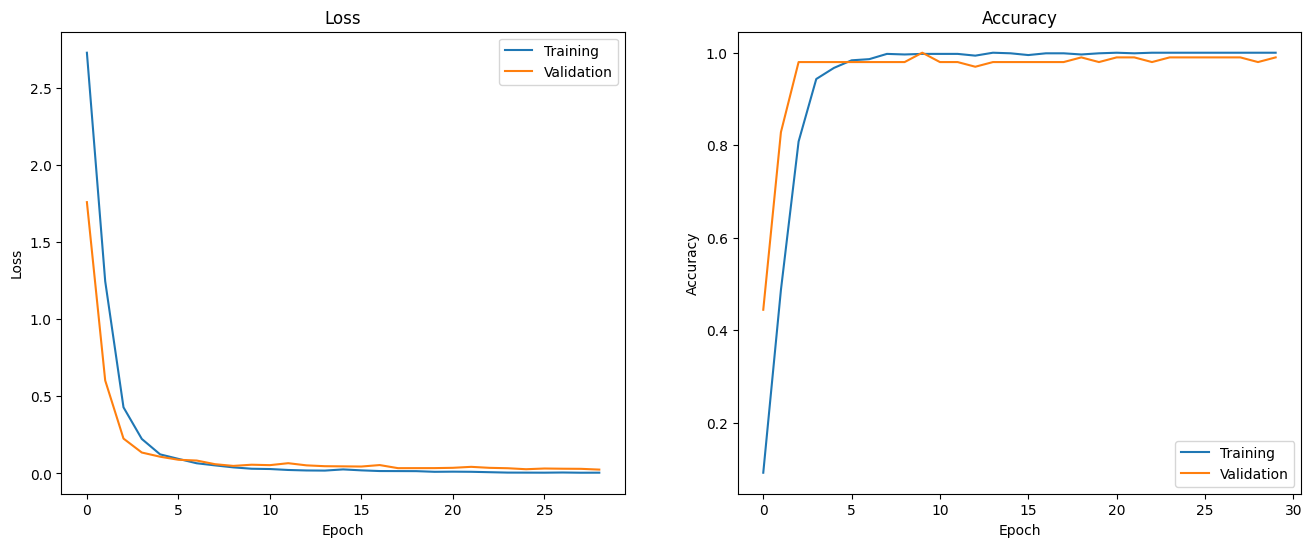

In [54]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.title('Accuracy')

In [55]:
submission  = scaler.transform(test_combined)

In [56]:
probs = model.predict(submission)
species_names = le.classes_  
df_probs = pd.DataFrame(probs, columns=species_names)
df_probs.insert(0, "id", test_combined.index.values)
df_probs.head()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.045941e-09,1.354804e-08,1.893804e-08,4.049593e-08,2.014267e-09,3.722257e-09,1.826603e-09,1.323648e-08,3.680976e-07,...,1.612562e-09,3.492068e-07,7.674349e-08,5.418561e-08,5.480580e-07,2.572040e-09,3.803520e-09,1.019762e-08,2.316132e-05,6.796616e-07
1,7,7.008937e-09,1.461019e-08,3.700071e-07,2.076248e-06,7.703183e-10,1.104262e-09,2.491610e-07,7.490038e-08,1.089624e-07,...,1.906935e-06,1.261857e-06,9.602670e-10,8.826540e-10,2.315099e-11,3.398213e-06,2.080377e-07,1.421656e-06,1.033412e-10,1.630510e-06
2,9,5.632208e-07,9.963531e-01,2.543004e-05,6.302431e-08,2.259377e-03,2.530057e-06,1.060248e-05,2.454274e-04,3.442916e-04,...,8.098257e-06,2.866712e-09,6.466278e-08,8.439337e-06,3.967961e-07,8.040483e-07,5.877785e-06,3.221961e-10,7.051196e-10,6.165073e-06
3,12,3.810198e-08,5.130593e-05,4.635195e-08,9.519971e-11,3.785231e-07,1.426991e-08,8.194837e-08,1.016637e-06,2.102632e-06,...,3.990277e-06,5.313450e-10,1.788635e-06,3.995621e-08,5.872036e-07,3.666591e-06,4.473250e-03,5.997175e-08,2.366567e-09,8.576711e-07
4,13,3.822860e-07,3.607522e-05,1.414060e-07,1.750715e-09,3.498229e-08,7.194485e-08,6.661253e-08,4.276446e-07,3.114541e-05,...,1.122600e-07,1.760624e-09,3.495358e-06,9.172173e-07,3.831059e-06,6.437869e-06,2.738756e-05,1.754170e-07,1.107823e-08,1.022486e-07


In [57]:
df_probs[le.classes_].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
589    1.0
590    1.0
591    1.0
592    1.0
593    1.0
Length: 594, dtype: float32

In [ ]:
# df_probs.to_csv("species_probabilities_NN.csv", index=False)